In [1]:
import os
from os import path
import glob
import librosa
from tqdm import tqdm
import pandas as pd
import json
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

# Utilities

In [2]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: the file path to the image

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    return np.broadcast_to(np.array(image.getdata()).reshape((im_height, im_width, 1)).astype(np.uint8),
                           (im_height, im_width, 3))

In [3]:
dataset_dir = "/home/jackson/Projects/marine-acoustics-2021/data/spectrograms-1600Hz-15s-300px-PCEN-082521/"
dataset_metadata_name = "dataset_metadata.txt"
eval_ids = [
    "671658014.180928183606",
    "671658014.180928213604",
    "671658014.180929063556",
    "671658014.180929093553",
    "671658014.180929183547",
    "671658014.180930153534"
]
min_score = 0.2

with open(path.join(dataset_dir, dataset_metadata_name)) as json_file:
    dataset_metadata = json.load(json_file)

eval_image_paths = []
for eid in eval_ids:
    eval_image_paths.extend(glob.glob(os.path.join(dataset_dir, "{}-*.png".format(eid))))
    
image_duration = dataset_metadata["EVAL_CHUNK_SIZE_SEC"]
image_duration_step = dataset_metadata["EVAL_CHUNK_STEP_SEC"]

freq_axis_low, freq_axis_high = librosa.hz_to_mel(0.0), librosa.hz_to_mel(dataset_metadata["FREQUENCY_MAX"])
freq_axis_diff = freq_axis_high - freq_axis_low

In [4]:
MODELS = {'baseline_run1': 'baseline_ssd_300x300_mobilenet_v2',
          'baseline_run2': 'baseline_ssd_300x300_mobilenet_v2_run2',
          'PCEN_run1': 'PCEN_ssd_300x300_mobilenet_v2',
          'PCEN_run2': 'PCEN_ssd_300x300_mobilenet_v2_run2'}

model_display_name = 'PCEN_run2'
model_ckpt_num = 'ckpt-55'
model_name = MODELS[model_display_name]

In [5]:
pipeline_config = os.path.join('/home/jackson/Projects/marine-acoustics-2021/models',
                                model_name, 'baseline.config')
model_dir = os.path.join('/home/jackson/Projects/marine-acoustics-2021/models',
                                model_name)

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(model_dir, model_ckpt_num)).expect_partial()

In [6]:
def get_model_detection_function(model):
    """Get a tf.function for detection."""

    @tf.function
    def detect_fn(image):
        """Detect objects in image."""

        image, shapes = model.preprocess(image)
        prediction_dict = model.predict(image, shapes)
        detections = model.postprocess(prediction_dict, shapes)

        return detections, prediction_dict, tf.reshape(shapes, [-1])

    return detect_fn

detect_fn = get_model_detection_function(detection_model)

In [7]:
# Also called "Jaccard Index"
def IOU(box1, box2):
    # (left, right, top, bottom) is the box order
    l1, r1, t1, b1 = box1
    l2, r2, t2, b2 = box2
    
    # Quick check if boxes do not overlap
    # Time dimension (r/l) checked first since it is more likely to filter
    if r1 < l2 or r2 < l1 or t1 < b2 or t2 < b1:
        return 0.0
    
    # IOU Calculation
    intersection_area = (min(r1, r2) - max(l1, l2)) * (min(t1, t2) - max(b1, b2))
    union_area = (r1 - l1) * (t1 - b1) + (r2 - l2) * (t2 - b2) - intersection_area
    
    return intersection_area / union_area


def calculate_agreements(annotations, verbose=True):
    agreements = np.zeros(shape=(len(annotations), len(annotations)))
    iter1 = range(len(annotations))
    if verbose:
        iter1 = tqdm(iter1, desc='Calculating Agreements')
    for i1 in iter1:
        a1 = annotations.iloc[i1]
        mask = ((annotations["Begin Time (s)"] > a1["End Time (s)"])
                | (annotations["End Time (s)"] < a1["Begin Time (s)"]))
        for i2 in (~mask).to_numpy().nonzero()[0]:
            a2 = annotations.iloc[i2]
            # Left, Right, Top, Bottom
            agreements[i1, i2] = IOU((a1["Begin Time (s)"],
                                      a1["End Time (s)"],
                                      a1["High Freq (Hz)"],
                                      a1["Low Freq (Hz)"]),
                                     (a2["Begin Time (s)"],
                                      a2["End Time (s)"],
                                      a2["High Freq (Hz)"],
                                      a2["Low Freq (Hz)"]))
            agreements[i2, i1] = agreements[i1, i2]
    return agreements

In [8]:
# Found at https://github.com/amusi/Non-Maximum-Suppression/blob/master/nms.py
def nms(boxes, score, threshold=0.6):
    # If no bounding boxes, return empty list
    if len(boxes) == 0:
        return []

    # coordinates of bounding boxes
    start_x = boxes[:, 0]
    start_y = boxes[:, 1]
    end_x = boxes[:, 2]
    end_y = boxes[:, 3]

    # Picked bounding boxes
    picked = []

    # Compute areas of bounding boxes
    areas = (end_x - start_x + 1) * (end_y - start_y + 1)

    # Sort by confidence score of bounding boxes
    order = np.argsort(score)

    # Iterate bounding boxes
    while order.size > 0:
        # The index of largest confidence score
        index = order[-1]

        # Pick the bounding box with largest confidence score
        picked.append(index)

        # Compute ordinates of intersection-over-union(IOU)
        x1 = np.maximum(start_x[index], start_x[order[:-1]])
        x2 = np.minimum(end_x[index], end_x[order[:-1]])
        y1 = np.maximum(start_y[index], start_y[order[:-1]])
        y2 = np.minimum(end_y[index], end_y[order[:-1]])

        # Compute areas of intersection-over-union
        w = np.maximum(0.0, x2 - x1 + 1)
        h = np.maximum(0.0, y2 - y1 + 1)
        intersection = w * h

        # Compute the ratio between intersection and union
        ratio = intersection / (areas[index] + areas[order[:-1]] - intersection)

        left = np.where(ratio < threshold)
        order = order[left]

    print("Kept:", len(picked), "Total:", len(boxes), "Percent:", len(picked)/len(boxes))
        
    return picked

In [9]:
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)
label_id_offset = 1

In [10]:
predictions = {}

# Converts [0.0,1.0] box labels to the data's original Hz scale
# Based on the maximum frequency represented and the mel transform
def convert_to_hz(vals):
    return librosa.mel_to_hz((1.0 - vals) * freq_axis_diff + freq_axis_low)

for image_path in tqdm(eval_image_paths):
    image_rec_id, image_index = tuple(path.basename(image_path)[:-4].split("-"))
    image_index = int(image_index)

    image_np = load_image_into_numpy_array(image_path)
    input_tensor = tf.convert_to_tensor(
        np.expand_dims(image_np, 0), dtype=tf.float32)
    detections, _, _ = detect_fn(input_tensor)
    boxes = detections['detection_boxes'][0].numpy()
    classes = (detections['detection_classes'][0].numpy() + label_id_offset).astype(int)
    scores = detections['detection_scores'][0].numpy()
    indices_to_keep = (scores > min_score)

    if not indices_to_keep.any():
        # No detections, skip to next image.
        continue

    boxes = boxes[indices_to_keep]
    classes = classes[indices_to_keep]
    scores = scores[indices_to_keep]
    
    # Boxes are in (ymin, xmin, ymax, xmax) order with origin at top left
    pred_df = pd.DataFrame(
        {
            "Begin Time (s)": boxes[:, 1] * image_duration + (image_duration_step * image_index),
            "End Time (s)": boxes[:, 3] * image_duration + (image_duration_step * image_index),
            "Low Freq (Hz)": convert_to_hz(boxes[:, 2]),
            "High Freq (Hz)": convert_to_hz(boxes[:, 0]),
            "Species": np.array([category_index[c]["name"] for c in classes]),
            "Species Confidence": scores
        }
    )

    if image_rec_id not in predictions.keys():
        predictions[image_rec_id] = [pred_df]
    else:
        predictions[image_rec_id].append(pred_df)
    
for rec_id, preds in predictions.items():
    preds = pd.concat(preds)
    boxes = preds[["Begin Time (s)", "Low Freq (Hz)", "End Time (s)", "High Freq (Hz)"]].to_numpy()
    box_indices = nms(boxes, preds["Species Confidence"].to_numpy(), threshold=0.75)
    preds = preds.iloc[box_indices]
    preds.to_csv("{}-predictions.txt".format(rec_id), sep="\t", index=False)

  0%|          | 0/8628 [00:00<?, ?it/s]

INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0


100%|██████████| 8628/8628 [02:40<00:00, 53.88it/s] 


Kept: 10808 Total: 13495 Percent: 0.8008892182289737
Kept: 12951 Total: 16196 Percent: 0.7996418868856507
Kept: 2596 Total: 2921 Percent: 0.8887367339952071
Kept: 3471 Total: 4134 Percent: 0.839622641509434
Kept: 1461 Total: 1660 Percent: 0.8801204819277109
Kept: 2879 Total: 3370 Percent: 0.8543026706231454


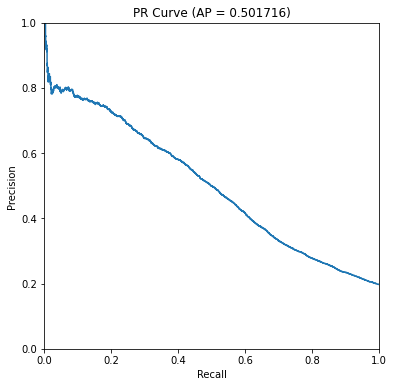

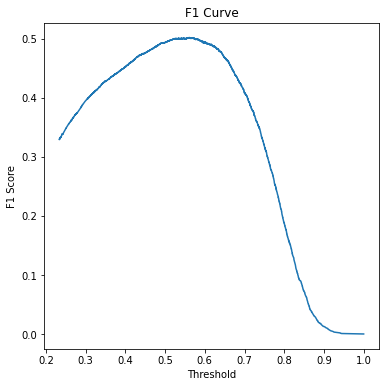

,Threshold,Precision,Recall,F1
0,1.000000,1.000000,0.000000,0.000000
1,0.973401,1.000000,0.000195,0.000390
2,0.944450,1.000000,0.000390,0.000780
3,0.941980,1.000000,0.000585,0.001170
4,0.941667,1.000000,0.000780,0.001559
...,...,...,...,...
25994,0.233680,0.197199,0.999805,0.329424
25995,0.233675,0.197192,0.999805,0.329413
25996,0.233666,0.197184,0.999805,0.329403
25997,0.233659,0.197177,0.999805,0.329392


In [11]:
def read_annotations(fname, verbose=False):
    annotations = pd.read_csv(fname, sep="\t")
    if verbose:
        print("Read {} annotations from {}".format(len(annotations), fname))
        print("Columns:", ",".join([" {} ({})".format(c, type(c)) for c in annotations.columns]))
    return annotations


def get_scores_and_pairings(preds_fname, annots_fname, iou_thresh, cls="hb"):
    preds = read_annotations(preds_fname)
    annots = read_annotations(annots_fname)
    annots = annots.loc[annots["Species"] == cls]
    agreements = np.zeros((len(preds), len(annots)))
    for i in range(len(preds)):
        pred_box = preds.iloc[i]
        mask = ((annots["Begin Time (s)"] > pred_box["End Time (s)"])
                | (annots["End Time (s)"] < pred_box["Begin Time (s)"]))
        for j in (~mask).to_numpy().nonzero()[0]:
            annot_box = annots.iloc[j]
            agreements[i, j] = IOU((pred_box["Begin Time (s)"],
                                    pred_box["End Time (s)"],
                                    pred_box["High Freq (Hz)"],
                                    pred_box["Low Freq (Hz)"]),
                                   (annot_box["Begin Time (s)"],
                                    annot_box["End Time (s)"],
                                    annot_box["High Freq (Hz)"],
                                    annot_box["Low Freq (Hz)"]))
    
    
    
    # return scores, has_pairing
    return preds["Species Confidence"], (agreements.max(axis=1) > iou_thresh), len(annots)


def render_ROC_curve(paired_fnames, thresholds=None, iou_thresh=0.5, save_name=None):
    if thresholds is None:
        thresholds = np.linspace(min_score, 1.0, num=40)
    
    all_scores, all_correct = [], []
    total_pos = 0
    for (preds_fname, annots_fname) in paired_fnames:
        scores, correct, n_pos = get_scores_and_pairings(preds_fname, annots_fname, iou_thresh)
        all_scores.append(scores)
        all_correct.append(correct)
        total_pos += n_pos
    all_scores = np.hstack(all_scores)
    all_correct = np.hstack(all_correct)
    
    # Sort by scores decreasing
    sort_indices = np.argsort(all_scores)[::-1]
    all_scores = all_scores[sort_indices]
    all_correct = all_correct[sort_indices]
    tps,fps = 0,0
    AP = 0.0
    precisions = [1.0]
    recalls = [0.0]
    thresholds = [1.0]
    prev_score = 1.0
    for score, correct in zip(all_scores, all_correct):
        if correct == 1.0:
            tps += 1
        else:
            fps += 1
        precisions.append(tps / (tps + fps))
        recalls.append(tps / total_pos)
        thresholds.append((prev_score + score) / 2)
        prev_score = score
        AP += (recalls[-1] - recalls[-2]) * precisions[-1]
        if tps == total_pos:
            break
    
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    f1_scores = (2 * recalls * precisions) / (recalls + precisions + 1e-12)
    
    plt.figure(figsize=(6,6))
    plt.plot(recalls, precisions)
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.title("PR Curve (AP = {:g})".format(AP))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()
    
    if save_name is not None:
        plt.savefig(save_name)
        
    plt.figure(figsize=(6,6))
    plt.plot(thresholds, f1_scores)
    plt.title("F1 Curve")
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.show()
    
    return pd.DataFrame({
        "Threshold": thresholds,
        "Precision": precisions,
        "Recall": recalls,
        "F1": f1_scores
    }), all_scores, all_correct

eval_ids
fnames = [
    ("671658014.180928183606-predictions.txt",
     "/home/jackson/Projects/marine-acoustics-2021/data/671658014.180928183606-AW.txt"),
    ("671658014.180928213604-predictions.txt",
     "/home/jackson/Projects/marine-acoustics-2021/data/671658014.180928213604-MS.txt"),
    ("671658014.180929063556-predictions.txt",
     "/home/jackson/Projects/marine-acoustics-2021/data/671658014.180929063556-MS.txt"),
    ("671658014.180929093553-predictions.txt",
     "/home/jackson/Projects/marine-acoustics-2021/data/671658014.180929093553-MS.txt"),
    ("671658014.180929183547-predictions.txt",
     "/home/jackson/Projects/marine-acoustics-2021/data/671658014.180929183547-MS.txt"),
    ("671658014.180930153534-predictions.txt",
     "/home/jackson/Projects/marine-acoustics-2021/data/671658014.180930153534-AW.txt")
]

res, scores, correct = render_ROC_curve(fnames)
res

In [12]:
res.loc[res["F1"] == res["F1"].max()]

,Threshold,Precision,Recall,F1
5496,0.560594,0.485444,0.520382,0.502306


<AxesSubplot:ylabel='Frequency'>

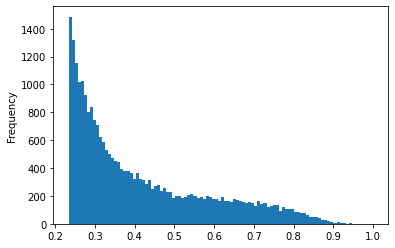

In [13]:
res["Threshold"].plot.hist(bins=100)

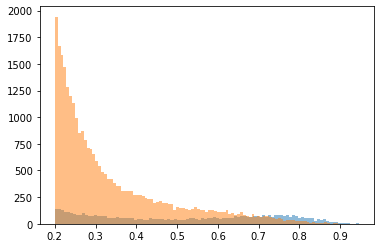

In [14]:
plt.hist(scores[correct == 1.0], bins=100, alpha=0.5)
plt.hist(scores[correct == 0.0], bins=100, alpha=0.5)
plt.show()